In [1]:
# Time for Greedy versus e-greedy example
import numpy as np
import random

number_of_arms=5
q_values = np.zeros(shape=(number_of_arms, 1))
q_values[2] = 5

def greedy_action_rule(_qv):
    return np.argmax(_qv)

print(q_values)
greedy_action_rule(q_values)

def e_greedy_rule(_qv, e_value):
    if random.uniform(0, 1.0) > e_value:
        print("EXPLOIT")
        return greedy_action_rule(_qv)
    else:
        print("EXPLORE")
        return random.randint(0, len(_qv) - 1)

for i in range(5):
    e_greedy_rule(q_values, 0.5)

[[0.]
 [0.]
 [5.]
 [0.]
 [0.]]
EXPLOIT
EXPLORE
EXPLORE
EXPLORE
EXPLOIT


In [46]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pow, e
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)
%load_ext autoreload
%autoreload 2
np.random.seed(5) # for reproduction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
class Environment():
    def __init__(self, armCount = 10, mean = 0.0, stddev = 1.0):
        self.armCount = armCount
        self.mean = mean
        self.stddev = stddev
        self.arms = np.arange(armCount)
        self.qStar = np.random.normal(mean, stddev, armCount)
        vMax = max(self.qStar)
        self.optimalChoice = np.random.choice(np.flatnonzero(self.qStar == vMax))
    
    def reward(self, chosen):
        return np.random.normal(self.qStar[chosen], scale = 1.0)

    def refresh(self):
        self.qStar = np.random.normal(self.mean, self.stddev, self.armCount)
        vMax = max(self.qStar)
        self.optimalChoice = np.random.choice(np.flatnonzero(self.qStar == vMax))


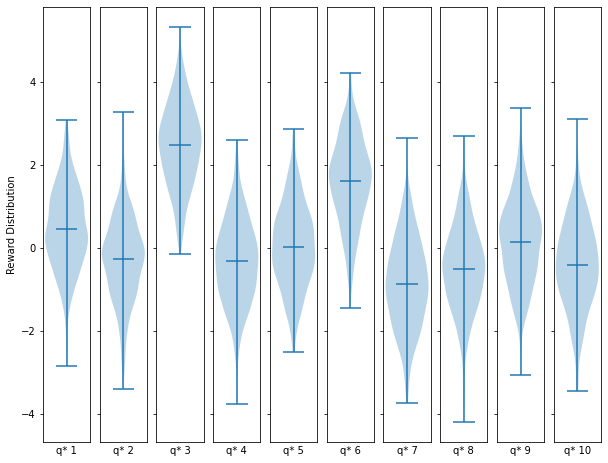

In [48]:
env = Environment()
%reload_ext autoreload
fig, axes = plt.subplots(1, env.armCount, sharey=True)
axes = axes.ravel()
for k, v in enumerate(env.qStar):
    ax = axes[k]
    ax.set_xticks([])
    data = np.random.normal(v, size=500)
    ax.violinplot(data, showmeans=True)
    ax.set_xlabel('q* ' + str(k + 1))
    if k == 0: ax.set_ylabel('Reward Distribution')

In [51]:
class GreedyAgent():
    def __init__(self, armCount):
        self.values = np.zeros(armCount) # estimated reward of each action
        self.pullCount = np.zeros(armCount) # number of pull for each lever
        self.armCount = armCount # number of arms
    def __repr__(self):
        return "Greedy"

    def selectArm(self):
        vMax = max(self.values)
        return np.random.choice(np.flatnonzero(self.values == vMax))

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (1/count) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)

In [52]:
agents = [GreedyAgent(env.armCount)]

In [53]:


class Sampling():
    
    def __init__(self, env, agents, play = 1000, run = 2000):
        self.env = env
        self.agents = agents
        self.play = play
        self.run = run
        self.colors = ['black', 'red', 'green', 'blue', 'magenta', 'cyan']
        self.rewardData = np.zeros((len(agents), play, run))
        self.optimalityData = np.zeros((len(agents), play, run))

    def start(self):
        for r in tqdm(range(self.run)):
            for p in range(self.play):
                for a in range(len(self.agents)):
                    choosen = self.agents[a].selectArm()
                    reward = self.env.reward(choosen)
                    self.agents[a].update(choosen, reward)
                    self.rewardData[a][p][r] += reward
                    if self.env.optimalChoice == choosen:
                        self.optimalityData[a][p][r] += 1
            self.env.refresh()
            for a in range(len(agents)):
                self.agents[a].refresh()



In [54]:
# Start the sampling process
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [00:46<00:00, 43.38it/s]


In [55]:
def plotResults(sample):
    rewardMean = np.mean(sample.rewardData, axis=2)
    optimalityMean = np.mean(sample.optimalityData, axis=2)
    time = np.array(list(range(sample.play)))

    for a in range(len(sample.agents)):
        plt.subplot(2, 1, 1)
        plt.plot(time, optimalityMean[a], '-o'
                , color=sample.colors[a], markersize=0.7, lw=1.5, label=str(sample.agents[a]))
        plt.ylabel('% Optimal Action')

        plt.subplot(2, 1, 2)
        plt.plot(time, rewardMean[a], '-o'
                , color=sample.colors[a], markersize=0.7, lw=1.5, label=str(sample.agents[a]))
        plt.ylabel('Average Reward')
        plt.xlabel('play')

    plt.legend(loc='best', fancybox=True)
    plt.show()

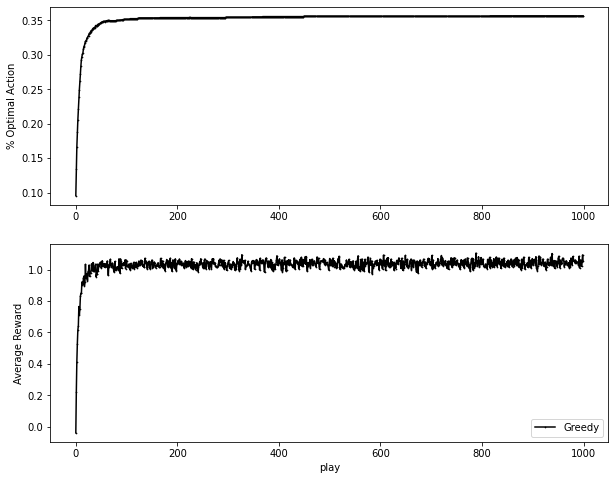

In [56]:
plotResults(sample)

In [57]:
class EpsilonGreedyAgent():
    def __init__(self, armCount, epsilon = 0.1):
        self.values = np.zeros(armCount)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.epsilon = epsilon

    def __repr__(self):
        return "Epsilon= " + str(self.epsilon)

    def selectArm(self):
        if np.random.rand() > self.epsilon: # Exploit
            vMax = max(self.values)
            return np.random.choice(np.flatnonzero(self.values == vMax))
        else: # Explore
            return np.random.choice(self.choice)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (1/count) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)

In [60]:
agents = [EpsilonGreedyAgent(env.armCount, 0.2), EpsilonGreedyAgent(env.armCount, 0.3), GreedyAgent(env.armCount)]
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [02:04<00:00, 16.09it/s]


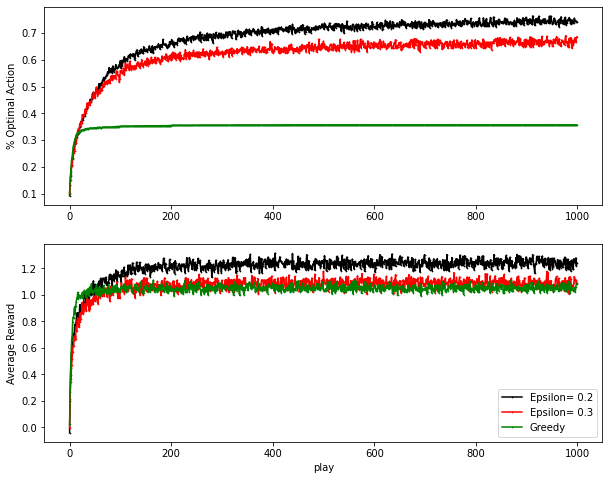

In [61]:
plotResults(sample)